# ANALISIS IRRADIANCIA OBTENIDA EN 1 DIA: SOLSTICIO DE VERANO

In [1]:
import module_Cell as cell
import module_AoiGrids as gr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pvlib import location
from pvlib import irradiance

Definimos como diccionarios los valores útiles del modulo y de las caracteristicas del lugar a estudiar. Tomamos un radio algo mayor que el spot, que en AOI=0 el spot es de radio aproximado 1mm

In [2]:
caracteristics_module={    
    'tilt':0, #Techo plano
    'surface_azimuth':180,
    'radius':1.2 #Radio inventado, se ha considerado que el spot en aoi=0 es sobre 1, entonces se ha puesto algo mayor
    }

caracteristics={
    'lat':40.405655,
    'lon':-3.647649,
    'tz':'Etc/GMT-2',
    'date':'2021-06-21',
    }

Trabajando con la librería pvlib obtenemos los datos para esta localización de la posición solar

In [3]:
site = location.Location(caracteristics['lat'], 
                         caracteristics['lon'],
                        caracteristics['tz'])
                                                      
times = pd.date_range(caracteristics['date'], freq='10min', periods=6*24,
                      tz=site.tz)
clearsky = site.get_clearsky(times)
solar_position = site.get_solarposition(times)

A partir de estos datos podemos obtener la distribución de irradiancias y el aoi a lo largo del día. 

In [4]:
total_irrad=irradiance.get_total_irradiance( 
    surface_tilt=caracteristics_module['tilt'],
    surface_azimuth=caracteristics_module['surface_azimuth'],
    dni=clearsky['dni'],
    ghi=clearsky['ghi'],
    dhi=clearsky['dhi'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

In [5]:
AOI_=irradiance.aoi( caracteristics_module['tilt'],
                   caracteristics_module['surface_azimuth'],
                   solar_position['apparent_zenith'], 
                   solar_position['azimuth'])

Para seguir los convenios elegidos, el AOI se decide pasar a negativo los valores mayores a 90º y se relaciona con el indice de tiempos. 

In [6]:
AOI=gr.transform_aoi(AOI_)
AOI.index = AOI.index.strftime("%H:%M")

## OBTENCIÓN ILUMINACIÓN 1 DÍA CON LA CÉLULA SIN MOVER

Definimos la célula en un punto fijo durante todo el día. Por comodidad tomamos el 0,0. Se opta por una celula circular, podría usarse también una celula rectangular: rectangular_cell(l1,l2,desx,desy,precision=0.04)

In [7]:
cell_grid=cell.circular_cell(caracteristics_module['radius'], 0, 0)


Calculamos el valor de la irradiancia total que atraviesa la célula. Primero la definimos copiando el AOI para que sea una matriz serie de iguales dimensiones y también indice de tiempos.

Para cada indice de tiempo: 
1. Guardamos en spot la matriz de distirbución de irradiación que tenemos como datos (csv)
2. Aplicamos intersección entre esta matriz y anterior y la matriz conformada por la celula.
    2.1 Los tramos de intersección, será irradiancia utilizada para electricidad
    2.2 Los tramos de no intersección, será irradiancia utilizada para iluminación <- LA QUE ESTAMOS ESTUDIANDO
3. Sumando todos los elementos de la matriz de intersección para iluminación tenemos ????????
4. Multiplicamos esta matriz por la irradiación directa total que obtenemos para ese tiempo y además sumamos toda la irradiación difusa. 
- Se ha hecho una función para esto, pero lo dejo ya desarrollado

In [8]:
irradiance = np.empty_like (AOI)
for i in range(len(times)):    
    spot=gr.spot_grid(AOI[i])
    area_illum,area_elect=cell.areas_intersection(spot,cell_grid)
    irradiance[i]=area_illum.sum()*total_irrad['poa_direct'][i]+total_irrad['poa_diffuse'][i]  

Dibujamos la distribución obtenida. 
En verde: irradiancia directa total
En naranja: irradiancia difusa
En azul: irradiancia obtenida para la iluminación que pasa a través de la célula

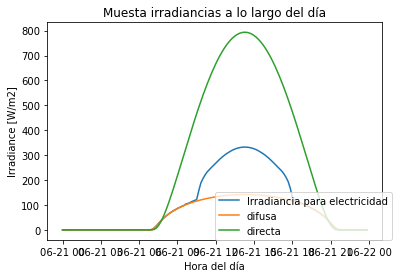

In [9]:
plt.plot(times,irradiance,label='Irradiancia para electricidad')
plt.plot(times,total_irrad['poa_diffuse'],label='difusa')
plt.plot(times,total_irrad['poa_direct'],label='directa')


plt.legend(loc=(0.5, 0))
plt.xlabel('Hora del día')
plt.ylabel('Irradiance [W/m2]')
plt.title("Muesta irradiancias a lo largo del día")

plt.show()

## OBTENCIÓN ILUMINACIÓN 1 DÍA CON LA CÉLULA MOVIENDOSE. OBJETIVO IRRADIANCIA PARA ILUMINACIÓN CONSTANTE


Definimos la célula pero no en un punto fijo durante todo el día. El objetivo va a ser dejar a 250W/m2 la irradiancia 

Se opta por una celula circular, podría usarse también una celula rectangular. Copiamos el valor de AOI para que sea una serie de igual dimensiones y con el indice de tiempos. Lo mismo con irradiance


 ## PROGRAMACIÓN DEL AJUSTE

Definimos el valor de irradiancia que queremos constante:

In [10]:
val_irradiance=250

Buscamos los limites en los que se consigue este valor, considerando que no hay celula y se consigue toda la irradiación. Concluimos que antes de la primera vez que se alcanza el valor deseado y después de la última vez, se va a buscar captar toda la irradiancia posible. (es decir la celula no tendrá interseccion con el spot)

In [11]:
a=0
for i in range(len(times)):    
    spot=gr.spot_grid(AOI[i])
    irradiance[i]=spot.sum()*total_irrad['poa_direct'][i]+total_irrad['poa_diffuse'][i]  
    if irradiance[i]>val_irradiance and a==0:
        a=1
        MIN_=i
    if irradiance[i]<val_irradiance and a==1:
        a=0
        MAX_=i

Sabemos que del estudio del spot obtenido para distintos aoi, el desplazamiento es:
1. 60º->40º desplazamiento positivo en x
2. 40º->0º desplazamiento negativo en x
3. 0º>AOI>-40º desplzamiento negativo en x
4. -40º>AOI>-60º desplazameinto positivo en x


Creamos un vector para guardar los valores dx,dy que se obtienen:

In [12]:
desp=np.empty(len(times),float)
for i in range(len(times)): 
    if i<=MIN_ or i>=MAX_:
        dx=0
        dy=3
        irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                        total_irrad['poa_diffuse'][i]) 
       
    else:
        if AOI[i]>0:
            dx=1.5
            dy=0
        else:
            dx=-1.5
            dy=0
        irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                      total_irrad['poa_diffuse'][i])       
        while irradiance[i]>1.05*val_irradiance or irradiance[i]<0.95*val_irradiance:
            if  AOI[i]>0:
                dx=dx-0.02
            elif AOI[i]<0:
                dx=dx+0.02
            else:
                dx=dx-0.02
            irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                           total_irrad['poa_diffuse'][i])    
            
    desp[i]=dx        
    

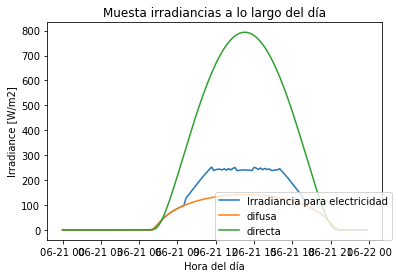

In [13]:
plt.plot(times,irradiance,label='Irradiancia para electricidad')
plt.plot(times,total_irrad['poa_diffuse'],label='difusa')
plt.plot(times,total_irrad['poa_direct'],label='directa')


plt.legend(loc=(0.5, 0))
plt.xlabel('Hora del día')
plt.ylabel('Irradiance [W/m2]')
plt.title("Muesta irradiancias a lo largo del día")

plt.show()

Comentario: El programa está simplificado puesto que solo hay aoi entre 40 a -40. Si se pide una irradiancai constante mas baja habría que revisar el programa. Además es muy poco eficiente a nivel del rendimiento(proceso muy lento)

Valor de dx obtenido:

In [14]:
print(desp)

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.8
  0.8   0.84  0.88  1.12  1.28  1.44  1.24  1.08  0.92  0.8   0.84  0.84
  0.84  0.84 -0.86 -0.86 -0.86 -0.86 -0.82 -0.9  -1.06 -1.22 -1.38 -1.34
 -1.18 -0.94 -0.9  -0.86 -0.78 -0.78  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


### PROBLEMAS DE INCOHERENCIA

#### 1. PASO DEL AOI NEGATIVO A POSITIVO

Al tener un tilt=0, no se consigue que el módulo tenga un aoi=0 en ningun momento. Para ello en Madrid se necesita en verano un tilt=17. Entonces, se obtiene una pequeña incoherencia a nivel del dibujo, cuando consideramos que se pasa a valores negativos:

1. Spot a las 14:10 AOI=17
2. Spot a a las 14.20 AOI=-17

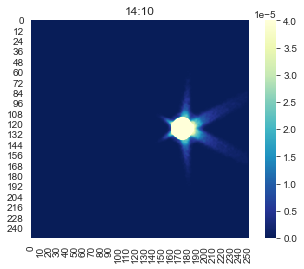

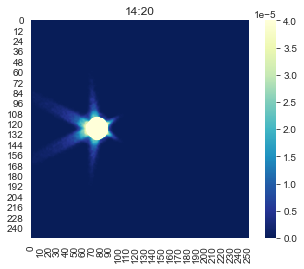

In [15]:
spot=gr.spot_grid(AOI[85])
gr.plot_grid('14:10',spot)
spot_2=gr.spot_grid(AOI[86])
gr.plot_grid('14:20',spot_2)

Por lo tanto también es incoherente el desplazamiento de la celula que se busca. Puesto que se pasa de un desplazamiento en x positivo a uno negativo. 